In [ ]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/DeepDream")

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import load_img, save_img, img_to_array
import keras.backend as K
import numpy as np
from matplotlib import pyplot as plt
import scipy.ndimage
import cv2

In [ ]:
"""Dynamic and Hyper parameters"""
layers_contribution = {
    "mixed2": 0.2,
    "mixed3": 3.0,
    "mixed4": 2.0,
    "mixed5": 1.5}

# layers_contribution = {"conv2d_52": 25.0}

lr = 0.01
epochs = 20
octave_scale = 1.4
n_octave = 3

max_loss = 10.
# max_loss = 100.

image_path = "jungle.jpeg"
save_path = "result.png"

In [ ]:
"""Any kind of process carried on image"""
def preprocess(image_path):

    img = load_img(image_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [ ]:
def deprocess(img):

    img = np.copy(img)
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img /= 2
    img += 0.5
    img *= 255

    img = np.clip(img, 0, 255).astype("uint8")

    return img

In [ ]:
def resize(img, size):

    img = np.copy(img)

    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order = 1)

In [ ]:
"""Model configuration"""
model = InceptionV3(weights = "imagenet", include_top = False)
layer_dict = {layer.name: layer for layer in model.layers}

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [ ]:
"""Loss configuration"""
loss = K.variable(0.0)
for layer_name, coeff in layers_contribution.items():
    outputs = layer_dict[layer_name].output
    scale = K.cast(K.prod(K.shape(outputs)), "float32")
    loss = loss + coeff * K.sum(K.square(outputs[:, 2:-2, 2:-2, :])) / scale

In [ ]:
"""Gradients configuration"""
dream = model.input
grads = K.gradients(loss, dream)[0]
grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())

fetch_loss_grads = K.function([dream], [loss, grads])

In [ ]:
def eval_loss_grads(x):
    loss_value, grad_values = fetch_loss_grads([x])
    return loss_value, grad_values

In [ ]:
def gradient_ascent(img, iterations, lr,  max_loss = None):

    for i in range(iterations):
        loss_value, grad_values = eval_loss_grads(img)
        print("iteration:{} loss:{}".format(i, loss_value))
        if max_loss is not None and loss_value > max_loss:
            break
        img += lr * grad_values
    return img

Processing shape:(93, 140)
iteration:0 loss:0.02914581261575222
iteration:1 loss:0.04058733955025673
iteration:2 loss:0.05328042060136795
iteration:3 loss:0.06816887855529785
iteration:4 loss:0.08245556056499481
iteration:5 loss:0.09618846327066422
iteration:6 loss:0.10785489529371262
iteration:7 loss:0.12167350947856903
iteration:8 loss:0.13226695358753204
iteration:9 loss:0.14345711469650269
iteration:10 loss:0.15504251420497894
iteration:11 loss:0.16288022696971893
iteration:12 loss:0.17502059042453766
iteration:13 loss:0.18593263626098633
iteration:14 loss:0.19435642659664154
iteration:15 loss:0.2042141556739807
iteration:16 loss:0.21413469314575195
iteration:17 loss:0.22219906747341156
iteration:18 loss:0.23244164884090424
iteration:19 loss:0.24068419635295868
Processing shape:(130, 196)
iteration:0 loss:0.9512365460395813
iteration:1 loss:1.5855748653411865
iteration:2 loss:2.0991268157958984
iteration:3 loss:2.590514659881592
iteration:4 loss:3.030176877975464
iteration:5 loss:3

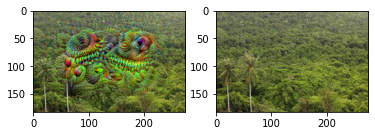

In [ ]:
"""Shaping"""

img = preprocess(image_path)
successive_shape = [img.shape[1:-1]]

for i in range(1, n_octave):
    shape = tuple([int(dim / (octave_scale ** i) )for dim in img.shape[1:-1]])
    successive_shape.append(shape)

successive_shape.reverse()
original_img = np.copy(img)
shrunk_img = resize(img, successive_shape[0])
"""Train and save result"""
for shape in successive_shape:
    print("Processing shape:{}".format(shape))

    img = resize(img, shape)
    img = gradient_ascent(img, epochs, lr, max_loss)

    downscale_img = resize(original_img, shape)
    upscale_img = resize(shrunk_img, shape)
    lost_details = downscale_img - upscale_img
    img += lost_details

    shrunk_img = resize(original_img, shape)
save_img(save_path, deprocess(img))
plt.figure()
plt.axis("off")
plt.subplot(121)
plt.imshow(deprocess(img))
plt.subplot(122)
plt.imshow(plt.imread('jungle.jpeg'))